In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
library(dplyr) 
library(themis)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Group Project Report

## Overview
The dataset includes two files:
- **players.csv**: Contains information about each unique player.
- **sessions.csv**: Contains details of individual play sessions for each player.

## Project Question
The question we want to answer is: *"How do experience level, age, and start time influence player behavior, particularly in terms of peak simultaneous activity and total session time played?"*

### Response and Explanatory Variables
- **Response Variable**: `number_of_simultaneous_players` (The number of players connected during specific time windows)
- **Explanatory Variables**: `start_time` (Start time of sessions), `end_time` (End time of sessions), `played_hours` (Total hours played by players)

### Explanation
Analyzing the session data, including `start_time`, `end_time`, and `played_hours`, will help identify patterns in player activity. This insight will allow us to forecast peak times and predict high-demand windows effectively. Understanding these patterns supports better resource management, ensuring the server can accommodate all parallel users efficiently.

## Variable Summary for `players_data`
| Variable Name       | Data Type    | Description                                    | Issues/Notes                          |
|---------------------|--------------|------------------------------------------------|---------------------------------------|
| `experience`        | Character    | Player's level of experience (e.g., Pro, Veteran, Amateur) | None                                 |
| `subscribe`         | Logical      | Indicates whether the player is subscribed (TRUE/FALSE) | None                                 |
| `hashedEmail`       | Character    | Hashed version of the player's email for identification | Used as an identifier, not human-readable |
| `played_hours`      | Numeric      | Total number of hours the player has played   | Check for outliers in high values    |
| `name`              | Character    | Player's first name                            | Potential data privacy concern       |
| `gender`            | Character    | Gender of the player (e.g., Male, Female)      | Ensure consistent formatting         |
| `age`               | Numeric      | Age of the player                              | Check for outliers (e.g., age = 99)  |
| `individualId`      | Logical      | Individual ID (all NA values)                  | All values are missing (NA)          |
| `organizationName`  | Logical      | Name of the player's organization (all NA values) | All values are missing (NA)          |

## Variable Summary for `sessions_data`
| Variable Name         | Data Type    | Description                                    | Issues/Notes                          |
|-----------------------|--------------|------------------------------------------------|---------------------------------------|
| `hashedEmail`         | Character    | Hashed version of the player's email for identification | Used as an identifier to link with `players_data` |
| `start_time`          | Character    | Start time of the play session (format: "DD/MM/YYYY HH:MM") | Needs conversion to datetime format |
| `end_time`            | Character    | End time of the play session (format: "DD/MM/YYYY HH:MM") | Needs conversion to datetime format |
| `original_start_time` | Numeric      | Original start time in a numeric format (timestamp) | Ensure consistency with `start_time` |
| `original_end_time`   | Numeric      | Original end time in a numeric format (timestamp) | Ensure consistency with `end_time`; 2 missing values |

## How Was the Data Collected?
The data was collected from a MineCraft server set up by a research group at UBC, which records player activity and session details as players interact with the game. This automated process captures data such as player demographics and session times, providing valuable insights into player behavior and server usage.


## Background Information 
Why is this research Important: This research is crucial for optimizing server resources, targeting recruitment efforts, and understanding player behavior in digital environments.

Potential Issues: While the data is automatically collected, potential inaccuracies can arise due to software glitches or server interruptions. For instance, session start and end times could be incorrectly logged if there is an issue with the server or if a player disconnects unexpectedly. Also, ensuring consistency across data types, especially start_time and end_time, which need to be converted to a datetime format, is crucial for accurate time-based analysis. Lastly,  Certain fields, such as individual Id and organizationName, are entirely missing (all values are NA). This might indicate that these variables are placeholders or not relevant to this version of the dataset, but it’s important to confirm their significance before analysis.

Player Demographics: The player demographic consists primarily of younger players, with the most common age range being 10-30 years. Players vary in experience, with a significant proportion identifying as "Regular" or "Amateur". 

In [3]:
#Reading the files
url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players_data <- read_csv(url_players)

url_sessions <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"
sessions_data <- read_csv(url_sessions)


Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Linear Regression

# Merge datasets on hashedEmail
merged_data <- merge(sessions_data, players_data, by = "hashedEmail")

# Convert start_time and end_time to datetime format
merged_data <- merged_data |>
    mutate(start_time = dmy_hm(start_time), end_time = dmy_hm(end_time))

# Create session_duration in minutes
merged_data <- merged_data |>
    mutate(session_duration = as.numeric(difftime(end_time, start_time, units = "mins")))

# Encode experience levels as numeric
# Beginner = 1, Amateur = 2, Regular = 3, Veteran = 4, Pro = 5
merged_data <- merged_data |>
    mutate(experience_encoded = as.numeric(factor(experience)))

# Filter necessary columns and remove missing values
filtered_data <- merged_data |>
    select(session_duration, experience_encoded, age) |>
    na.omit()

head(filtered_data)

,session_duration,experience_encoded,age
,<dbl>,<dbl>,<dbl>
1,45,4,20
2,61,4,20
3,30,3,21
4,11,2,17
5,36,4,17
6,37,4,17
7,59,4,17
8,20,4,17
9,31,4,17


In [9]:
sessions_select <- sessions_data |>
    select(start_time, end_time, hashedEmail)

sessions_seperate <- sessions_select |>
    separate(start_time, into = c("start_date", "start_time"), sep = " ") |>
    separate(end_time, into = c("end_date", "end_time"), sep = " ")

sessions_new <- sessions_seperate |>
   mutate(start_time = as.POSIXct(start_time, format = "%H:%M"),
          end_time = as.POSIXct(end_time, format = "%H:%M"),
         start_hour = hour(start_time),
         end_hour= hour(end_time))
 

players_new <- players_data |>
    select(hashedEmail,experience, played_hours, name, gender, age)


players_session <- full_join(sessions_new, players_new, by = "hashedEmail")


player_session_select <- players_session |>
    select(start_hour, experience) |>
    mutate(experience = as.factor(experience)) |>
    drop_na()

players_session <- full_join(sessions_new, players_new, by = "hashedEmail")
player_session_select <- players_session |>
    select(start_hour, experience, age) |>
    mutate(experience = as.factor(experience)) |>
    drop_na()

# Peak Playtime Histogram 

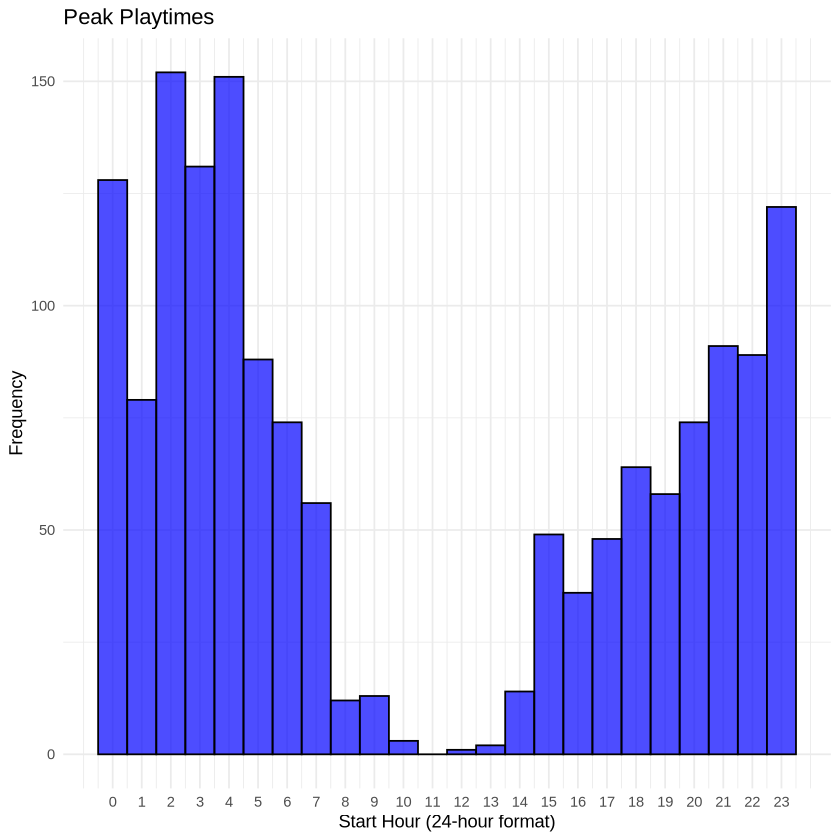

In [10]:
ggplot(player_session_select, aes(x = start_hour)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Peak Playtimes", 
       x = "Start Hour (24-hour format)", 
       y = "Frequency") +
  scale_x_continuous(breaks = seq(0, 23, 1)) +
  theme_minimal()

# Peak Playtime Histogram - For Age

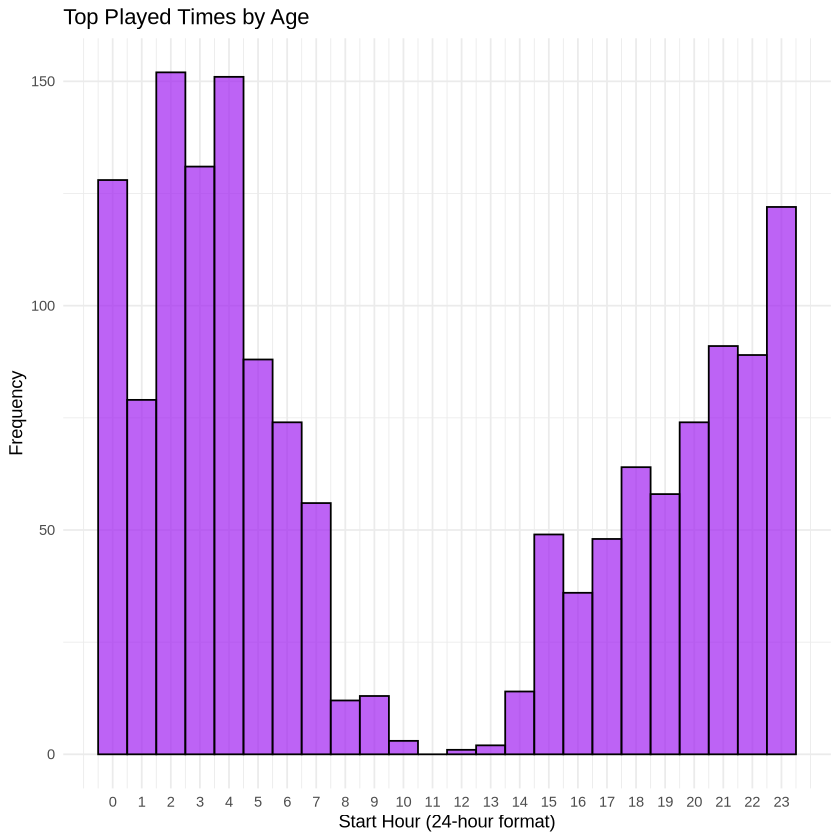

In [11]:
ggplot(player_session_select, aes(x = start_hour)) +
  geom_histogram(binwidth = 1, position = "dodge", fill = "purple", color = "black", alpha = 0.7) +
  labs(title = "Top Played Times by Age", 
       x = "Start Hour (24-hour format)", 
       y = "Frequency", 
       fill = "Age Group") +
  scale_x_continuous(breaks = seq(0, 23, 1)) +
  theme_minimal()

# Peak Playtime Histogram - For Experiance 

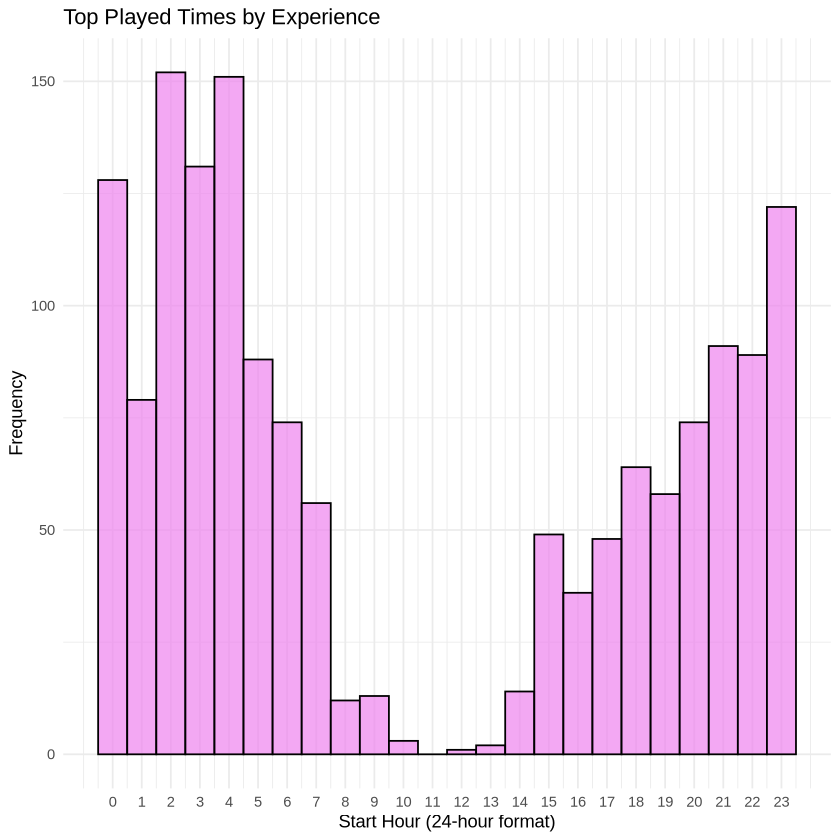

In [12]:
ggplot(player_session_select, aes(x = start_hour)) +
  geom_histogram(binwidth = 1, position = "dodge", fill = "violet", color = "black", alpha = 0.7) +
  labs(title = "Top Played Times by Experience", 
       x = "Start Hour (24-hour format)", 
       y = "Frequency", 
       fill = "Experience Level") +
  scale_x_continuous(breaks = seq(0, 23, 1)) +
  theme_minimal()

# Peak Playtime Histogram - For 20 Year Olds

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
       (Intercept)    session_duration  experience_encoded  
          19.41899            -0.29156             0.01132  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.80056377
rsq,standard,0.01957373
mae,standard,3.37862718


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)  session_duration               age  
        1.577166          0.010360          0.008456  


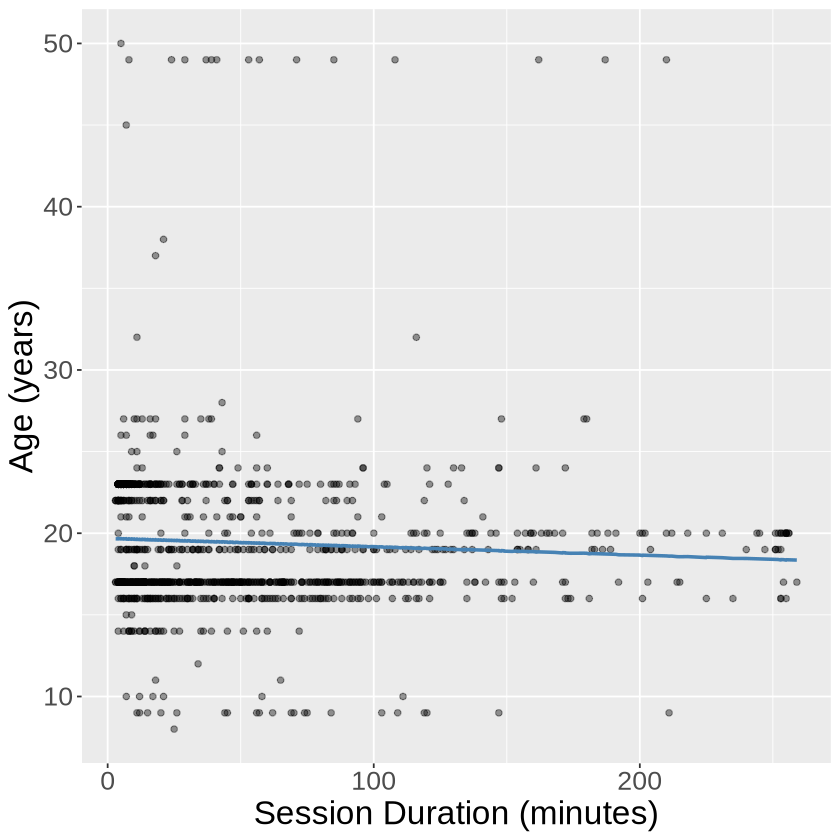

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.3632427
rsq,standard,0.1399335
mae,standard,1.1986106


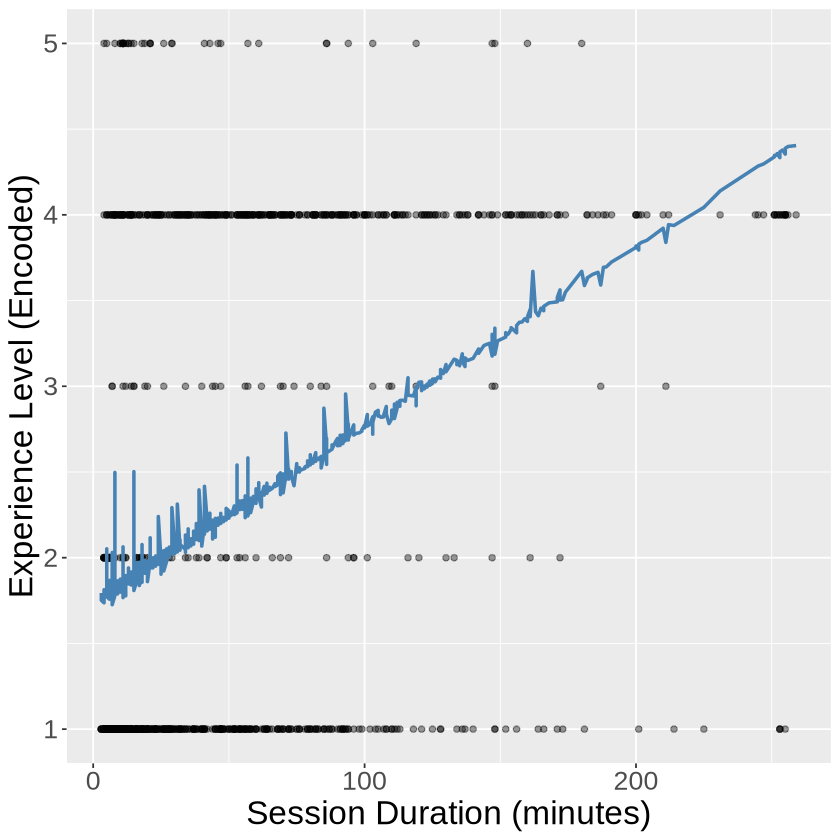

In [7]:
# Split the data into training (75%) and testing (25%) sets with stratification by 'age'
set.seed(123)  # For reproducibility
age_data_split <- initial_split(filtered_data, prop = 0.75, strata = age)
age_train_data <- training(age_data_split)
age_test_data <- testing(age_data_split)

# Model specification: Linear regression
age_lr_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

# Create a recipe for preprocessing
age_lr_recipe <- recipe(age ~ session_duration + experience_encoded, data = age_train_data) |>
    step_normalize(all_numeric_predictors())

# Fit the linear regression model
age_lr_workflow <- workflow() |>
    add_model(age_lr_spec) |>
    add_recipe(age_lr_recipe) |>
    fit(data = age_train_data)
age_lr_workflow

# Generate predictions for the training data
age_train_predictions <- age_train_data |>
    mutate(.pred = predict(age_lr_workflow, new_data = age_train_data)|> 
    pull(.pred))

# Create the plot using the specified template
age_plot_final <- ggplot(age_train_data, aes(x = session_duration, y = age)) +
    geom_point(alpha = 0.4) +
    geom_line(data = age_train_predictions,
        mapping = aes(x = session_duration, y = .pred),
        color = "steelblue",
        linewidth = 1) +
    xlab("Session Duration (minutes)") +
    ylab("Age (years)") +
    theme(text = element_text(size = 20))

# Print the plot
age_plot_final

# Evaluate the model on the test data for age
test_results_age <- age_lr_workflow |>
    predict(age_test_data) |>
    bind_cols(age_test_data) |>
    metrics(truth = age, estimate = .pred)
test_results_age


# Split the data into training (75%) and testing (25%) sets with stratification by 'experience_encoded'
set.seed(123)  # For reproducibility
experience_encoded_data_split <- initial_split(filtered_data, prop = 0.75, strata = experience_encoded)
experience_encoded_train_data <- training(experience_encoded_data_split)
experience_encoded_test_data <- testing(experience_encoded_data_split)

# Model specification: Linear regression
experience_encoded_lr_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

# Create a recipe for preprocessing
experience_encoded_lr_recipe <- recipe(experience_encoded ~ session_duration + age, data = experience_encoded_train_data) 

# Fit the linear regression model
experience_encoded_lr_workflow <- workflow() |>
    add_model(experience_encoded_lr_spec) |>
    add_recipe(experience_encoded_lr_recipe) |>
    fit(data = experience_encoded_train_data)
experience_encoded_lr_workflow

# Generate predictions for the training data
train_predictions_exp <- experience_encoded_train_data |>
    mutate(.pred = predict(experience_encoded_lr_workflow, new_data = experience_encoded_train_data)|> 
    pull(.pred))

# Create the plot for experience_encoded using the same template
experience_encoded_plot_exp <- ggplot(experience_encoded_train_data, aes(x = session_duration, y = experience_encoded)) +
    geom_point(alpha = 0.4) +
    geom_line(data = train_predictions_exp,
        mapping = aes(x = session_duration, y = .pred),
        color = "steelblue",
        linewidth = 1) +
    xlab("Session Duration (minutes)") +
    ylab("Experience Level (Encoded)") +
    theme(text = element_text(size = 20))

# Print the plot
experience_encoded_plot_exp

# Evaluate the model on the test data for experience_encoded
test_results_exp <- experience_encoded_lr_workflow |>
    predict(experience_encoded_test_data) |>
    bind_cols(experience_encoded_test_data) |>
    metrics(truth = experience_encoded, estimate = .pred)
test_results_exp